<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_23_MaskRCNN_InstanceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 День 23 — Instance Segmentation: Mask R-CNN

## 🔹 Основное задание: Mask R-CNN
Мы изучим **архитектуру Mask R-CNN**, которая позволяет производить Instance Segmentation — то есть выделение **отдельных объектов одного класса** с индивидуальными масками.

Mask R-CNN — это расширение Faster R-CNN с дополнительной веткой для предсказания **маски объекта** поверх каждого предсказанного bounding box.

### 📐 Архитектура:
- **Backbone (ResNet + FPN)** — извлечение признаков
- **Region Proposal Network (RPN)** — генерация регионов интереса (RoI)
- **RoIAlign** — выравнивание регионов
- **Classifier + BBox regressor** — классификация и уточнение BBox
- **Mask head** — сверточная сеть, предсказывающая маску (обычно 28x28)

### 📘 Формула полной проекции:
$$ P = K [R | t] $$
где:
- $K$ — внутренняя матрица камеры
- $[R | t]$ — матрица поворота и смещения (экструзия)

### 📊 Что нужно реализовать:
- Использовать предобученную Mask R-CNN модель из `torchvision`
- Применить её к реальному изображению
- Отрисовать маски, bounding box'ы и метки классов
- Проанализировать результаты

In [1]:
# Импорт библиотек
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'images.cocodataset.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Text(0.5, 1.0, 'Исходное изображение')

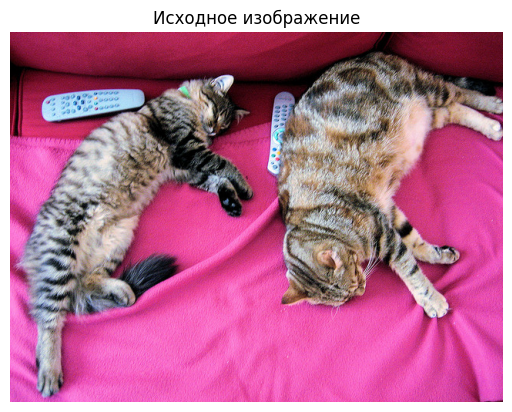

In [3]:
# Загрузка изображения
url = 'https://images.cocodataset.org/val2017/000000039769.jpg'
response = requests.get(url, verify=False)
image = Image.open(BytesIO(response.content)).convert("RGB")
plt.imshow(image); plt.axis('off'); plt.title('Исходное изображение')

In [4]:
# Преобразование изображения и предсказание
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

input_tensor = F.to_tensor(image).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)[0]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 322MB/s]


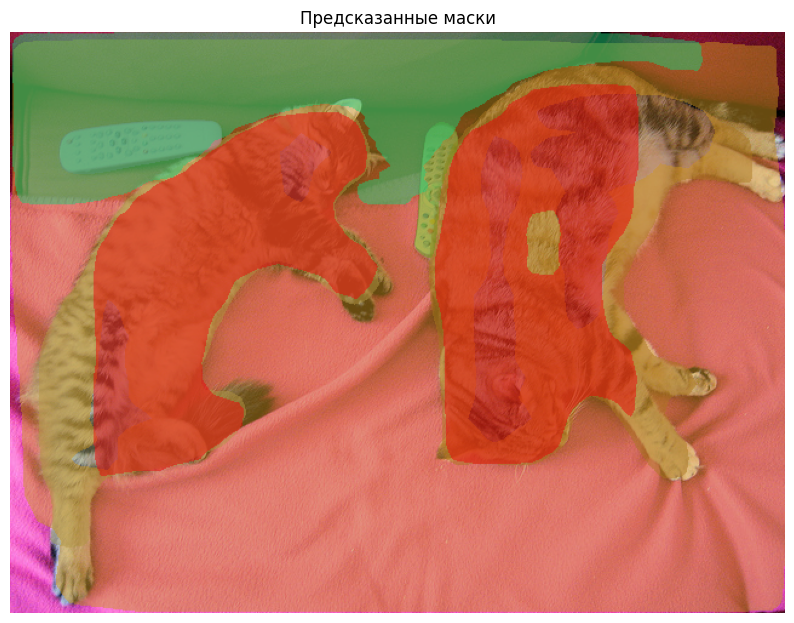

In [5]:
# Визуализация результатов
def draw_instance_predictions(image_pil, output, threshold=0.5):
    image = np.array(image_pil.copy())
    for i in range(len(output['scores'])):
        if output['scores'][i] > threshold:
            mask = output['masks'][i, 0].mul(255).byte().cpu().numpy()
            label = output['labels'][i].item()
            color = np.random.randint(0, 255, (3,), dtype=np.uint8)
            image[mask > 127] = image[mask > 127] * 0.5 + color * 0.5
    plt.figure(figsize=(10,10))
    plt.imshow(image); plt.axis('off'); plt.title('Предсказанные маски')
draw_instance_predictions(image, output)

## 🔸 OpenCV: Визуализация масок и контуров объектов
Мы научимся использовать OpenCV-функции для рисования контуров объектов, предсказанных Mask R-CNN.

**Методы:**
- `cv2.findContours`
- `cv2.drawContours`
- `cv2.polylines`


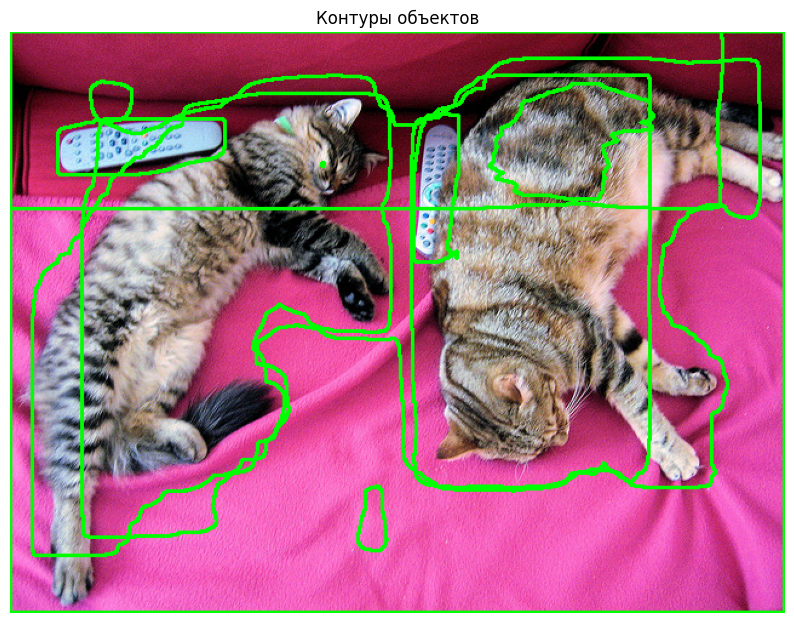

In [6]:
# Отрисовка контуров через OpenCV
def draw_contours_with_opencv(image_pil, output, threshold=0.5):
    image = np.array(image_pil.copy())
    for i in range(len(output['scores'])):
        if output['scores'][i] > threshold:
            mask = output['masks'][i, 0].mul(255).byte().cpu().numpy()
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    plt.figure(figsize=(10,10))
    plt.imshow(image); plt.axis('off'); plt.title('Контуры объектов')
draw_contours_with_opencv(image, output)

## 🔸 Линейная алгебра: Матрица камеры и Extrinsics
**Матрица камеры (внутренние параметры):**
$$
K = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

**Внешние параметры (экструзия):**
$$
[R|t] = \begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z
\end{bmatrix}
$$

**Полная проекционная матрица:**
$$ P = K[R|t] $$

Она используется для отображения 3D-точек в 2D-изображение.

In [7]:
# Пример вычисления проекционной матрицы
import numpy as np

# Внутренняя матрица
K = np.array([[1000, 0, 320],
              [0, 1000, 240],
              [0, 0, 1]])

# Внешние параметры: поворот + смещение
R = np.eye(3)
t = np.array([[0], [0], [-5]])
Rt = np.hstack((R, t))

# Полная проекционная матрица
P = K @ Rt
print("Проекционная матрица:\n", P)

Проекционная матрица:
 [[ 1.0e+03  0.0e+00  3.2e+02 -1.6e+03]
 [ 0.0e+00  1.0e+03  2.4e+02 -1.2e+03]
 [ 0.0e+00  0.0e+00  1.0e+00 -5.0e+00]]


# 🔸 Линейная алгебра: Матрица камеры и Extrinsics

## 🎯 Цель
Преобразовать 3D-точку из мировой системы координат в 2D-точку на изображении с помощью проекционной модели камеры.

---

## 🧩 Модель камеры: от 3D к 2D

Мы хотим получить:

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
=
P \cdot
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

где:
- \( [X, Y, Z] \) — координаты точки в **мировой системе**
- \( [u, v] \) — координаты пикселя в изображении
- \( P \in \mathbb{R}^{3 \times 4} \) — **проекционная матрица камеры**

---

## 📷 Внутренние параметры камеры (Intrinsics)

Описывают характеристики самой камеры: фокус, разрешение и центр кадра.

Матрица \( K \):

$$
K =
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

где:
- \( f_x, f_y \) — фокусные расстояния по x и y (в пикселях)
- \( c_x, c_y \) — координаты **оптического центра** (обычно центр изображения)

---

## 🌍 Внешние параметры (Extrinsics)

Описывают положение и ориентацию камеры в пространстве.

Комбинация поворота и смещения:

$$
[R \,|\, t] =
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z
\end{bmatrix}
$$

- \( R \in \mathbb{R}^{3 \times 3} \) — **матрица поворота**
- \( t \in \mathbb{R}^{3 \times 1} \) — **вектор смещения**

---

## 🔗 Полная проекционная матрица

Формируется как:

$$
P = K \cdot [R \,|\, t]
$$

- \( P \in \mathbb{R}^{3 \times 4} \)
- Используется для перехода из 3D в 2D

---

## 📐 Пример преобразования точки

Допустим, есть 3D-точка:

$$
\mathbf{X}_{world} =
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

Проекцией будет:

$$
\mathbf{x}_{image} = P \cdot \mathbf{X}_{world} =
\begin{bmatrix}
u \\
v \\
w
\end{bmatrix}
\Rightarrow
(u', v') =
\left(
\frac{u}{w}, \frac{v}{w}
\right)
$$

---

## 🧠 Почему это важно

- Это основа **проецирования**, **глубины**, **stereo matching**, **SLAM**, **3D реконструкции**, и т.д.
- Используется во всех CV-библиотеках: OpenCV, COLMAP, SLAM-пайплайны

---

## 📚 Связанные функции в OpenCV

- `cv2.projectPoints()`
- `cv2.calibrateCamera()`
- `cv2.Rodrigues()` (поворот → матрица)



# 🔭 Симуляция камеры и проекции 3D-точек в 2D
В этом ноутбуке ты увидишь, как работают **внутренние и внешние параметры камеры**, и как они формируют проекцию 3D-точек в 2D-изображение.

Ты сможешь менять положение камеры и видеть, как меняется результат проекции.

## 📌 Параметры камеры
Матрица камеры включает:
- **Фокусные расстояния** $f_x, f_y$
- **Оптический центр** $c_x, c_y$
- **Ориентация (матрица поворота R)** и **позиция (вектор смещения t)**

In [8]:
# Импорты
import numpy as np
import matplotlib.pyplot as plt

## ⚙️ Настройка параметров камеры

In [9]:
# Внутренние параметры камеры (матрица K)
f_x, f_y = 800, 800  # фокус в пикселях
c_x, c_y = 320, 240  # оптический центр

K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0, 0, 1]])
print('K =\n', K)

K =
 [[800   0 320]
 [  0 800 240]
 [  0   0   1]]


In [10]:
# Внешние параметры камеры (матрица R и вектор t)
theta = np.radians(0)  # угол поворота вокруг оси Y
R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                [0, 1, 0],
                [-np.sin(theta), 0, np.cos(theta)]])

t = np.array([[0], [0], [-5]])  # смещение вдоль оси Z
Rt = np.hstack((R_y, t))
print('[R|t] =\n', Rt)

[R|t] =
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [-0.  0.  1. -5.]]


## 🎯 Создание 3D-точек

In [11]:
# Пример: несколько точек в 3D-пространстве
points_3d = np.array([
    [0, 0, 10, 1],
    [1, 1, 10, 1],
    [-1, 1, 10, 1],
    [1, -1, 10, 1],
    [-1, -1, 10, 1],
    [0, 0, 15, 1]
]).T  # форма (4, N)
print('Точки в мировой системе координат:\n', points_3d.T)

Точки в мировой системе координат:
 [[ 0  0 10  1]
 [ 1  1 10  1]
 [-1  1 10  1]
 [ 1 -1 10  1]
 [-1 -1 10  1]
 [ 0  0 15  1]]


## 🔄 Проекция в 2D

In [12]:
# Полная проекционная матрица
P = K @ Rt

# Проецирование всех точек
points_2d_homog = P @ points_3d  # (3, N)
points_2d = points_2d_homog[:2] / points_2d_homog[2]  # нормализация
points_2d = points_2d.T  # (N, 2)
print('Проецированные точки (u, v):\n', points_2d)

Проецированные точки (u, v):
 [[320. 240.]
 [480. 400.]
 [160. 400.]
 [480.  80.]
 [160.  80.]
 [320. 240.]]


## 🖼 Визуализация результата

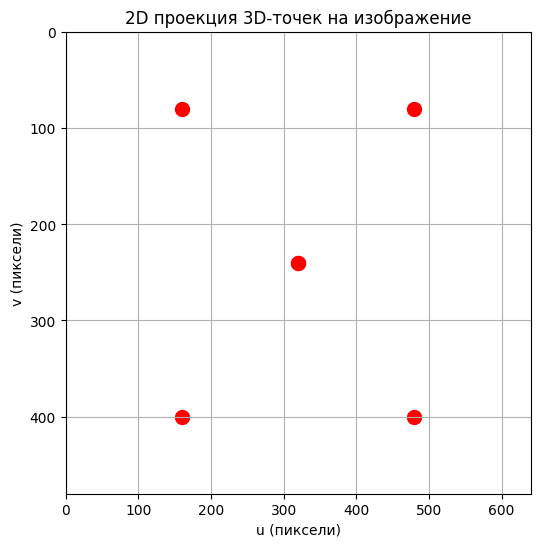

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], c='red', s=100)
plt.xlim(0, 640)
plt.ylim(480, 0)
plt.title('2D проекция 3D-точек на изображение')
plt.xlabel('u (пиксели)')
plt.ylabel('v (пиксели)')
plt.grid(True)
plt.show()